In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
PATH = '/content/drive/My Drive/PPM_Stability/'
#PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/n9455647/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [ ]:
#!pip install pandas==0.22.0
#!pip install xgboost==1.0.0

In [ ]:
import EncoderFactory
from DatasetManager_for_colab import DatasetManager
import BucketFactory

import pandas as pd
import numpy as np
import random

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support	

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import catboost

from tensorflow.keras.backend import print_tensor
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing import sequence
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Embedding, Flatten, Input
from keras.layers import LSTM
from keras.optimizers import Nadam, RMSprop
from tensorflow.keras.utils import plot_model
from keras.layers.normalization import BatchNormalization

import seaborn as sns

#import lime
#import lime.lime_tabular
#from lime import submodular_pick;
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import joblib

In [ ]:
def train_with_unbalanced_data(X_train, X_test, feature_combiner, dataset_manager, current_args, scaler = None, iterations = 10):
  #index = np.arange(0, len(y_train), 1)
  #X_train = X_train.reindex(index)

  all_pipelines = []
  all_cls = []
  all_acc = []

  for i in range(iterations):

    #X_train_enc = feature_combiner.fit_transform(X_train, y_train)

    y_train = dataset_manager.get_label_numeric(X_train)
    #print(len(y_train))
    case_ids = dataset_manager.get_case_ids(X_train)
    #print(case_ids.shape)

    #Reduce to balanced dataset
    neg_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 0]
    pos_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 1]
    
    if len(neg_cases) > len(pos_cases):
      to_keep = random.sample(neg_cases, len(pos_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(pos_cases)])
    elif len(neg_cases) < len(pos_cases):
      to_keep = random.sample(pos_cases, len(neg_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(neg_cases)])

    y_train_resampled = dataset_manager.get_label_numeric(X_train_resampled)

    #Train model
    if cls_method == "rf":
      cls = RandomForestClassifier(n_estimators=500,
                                  max_features=current_args['max_features'],
                                  random_state=random_state)

    elif cls_method == "xgboost":
      cls = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=500,
                              learning_rate= current_args['learning_rate'],
                              subsample=current_args['subsample'],
                              max_depth=int(current_args['max_depth']),
                              colsample_bytree=current_args['colsample_bytree'],
                              min_child_weight=int(current_args['min_child_weight']),
                              seed=random_state)

    elif cls_method == "logit":
      cls = LogisticRegression(C=2**current_args['C'],
                              random_state=random_state)

    elif cls_method == "svm":
      cls = SVC(C=2**current_args['C'],
                gamma=2**current_args['gamma'],
                random_state=random_state)

    if cls_method == "svm" or cls_method == "logit":
      pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
    else:
      pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

    #print("fitting pipeline...")
    pipeline.fit(X_train_resampled, y_train_resampled)

    #Test Model
    test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
    y_test = [dataset_manager.get_label_numeric(group) for _,group in test_all_grouped]

    preds = pipeline.predict(X_test)
    #print(preds)
    acc = accuracy_score(y_test, preds)

    #save to list
    all_pipelines.append(pipeline)
    all_cls.append(cls)
    all_acc.append(acc)
  
  print("Accuracy Scores:", all_acc)
  print("Highest accuracy:", max(all_acc))
  print("Index:", all_acc.index(max(all_acc)))

  return pipeline, cls

{'lstm_layers': {'lstm2_dropouts': 0.18,
  'lstm3_dropouts': 0.18,
  'lstm2_nodes': 30,
  'lstm3_nodes': 30,
  'layers': 'three'},
 'dense_layers': {'layers': 'one', 'dense2_nodes': 8},
 'learning_rate': 3e-05,
 'lstm1_nodes': 30,
 'batch_size': 8,
 'lstm1_dropouts': 0.18,
 'optimizer': 'adam',
 'epochs': 100}

In [ ]:
def train_lstm_with_unbalanced_data(train, test, val, dataset_manager, current_args, scaler = None, iterations = 10):
  #index = np.arange(0, len(y_train), 1)
  #X_train = X_train.reindex(index)

  all_pipelines = []
  all_cls = []
  all_acc = []

  for i in range(iterations):

    #X_train_enc = feature_combiner.fit_transform(X_train, y_train)

    y_train = dataset_manager.get_label_numeric(X_train)
    #print(len(y_train))
    case_ids = dataset_manager.get_case_ids(X_train)
    #print(case_ids.shape)

    #Reduce to balanced dataset
    neg_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 0]
    pos_cases = [case_ids[i] for i in range(len(y_train)) if y_train[i] == 1]
    
    if len(neg_cases) > len(pos_cases):
      to_keep = random.sample(neg_cases, len(pos_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(pos_cases)])
    elif len(neg_cases) < len(pos_cases):
      to_keep = random.sample(pos_cases, len(neg_cases))
      X_train_resampled = X_train.loc[X_train[dataset_manager.case_id_col].isin(to_keep)]
      X_train_resampled = X_train_resampled.append(X_train.loc[X_train[dataset_manager.case_id_col].isin(neg_cases)])

    y_train_resampled = dataset_manager.get_label_numeric(X_train_resampled)

    #Train model
    if cls_method == "rf":
      cls = RandomForestClassifier(n_estimators=500,
                                  max_features=current_args['max_features'],
                                  random_state=random_state)

    elif cls_method == "xgboost":
      cls = xgb.XGBClassifier(objective='binary:logistic',
                              n_estimators=500,
                              learning_rate= current_args['learning_rate'],
                              subsample=current_args['subsample'],
                              max_depth=int(current_args['max_depth']),
                              colsample_bytree=current_args['colsample_bytree'],
                              min_child_weight=int(current_args['min_child_weight']),
                              seed=random_state)

    elif cls_method == "logit":
      cls = LogisticRegression(C=2**current_args['C'],
                              random_state=random_state)

    elif cls_method == "svm":
      cls = SVC(C=2**current_args['C'],
                gamma=2**current_args['gamma'],
                random_state=random_state)

    if cls_method == "svm" or cls_method == "logit":
      pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
    else:
      pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

    #print("fitting pipeline...")
    pipeline.fit(X_train_resampled, y_train_resampled)

    #Test Model
    test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
    y_test = [dataset_manager.get_label_numeric(group) for _,group in test_all_grouped]

    preds = pipeline.predict(X_test)
    #print(preds)
    acc = accuracy_score(y_test, preds)

    #save to list
    all_pipelines.append(pipeline)
    all_cls.append(cls)
    all_acc.append(acc)
  
  print("Accuracy Scores:", all_acc)
  print("Highest accuracy:", max(all_acc))
  print("Index:", all_acc.index(max(all_acc)))

  return pipeline, cls

In [ ]:
dataset_ref = "production"
params_dir = PATH + "params/"
results_dir = "results"
bucket_method = "single"
cls_encoding = "3d"
cls_method = "lstm"
gap = 1
n_iter = 1
balanced_data = False

if bucket_method == "state":
    bucket_encoding = "last"
else:
    bucket_encoding = "agg"

method_name = "%s_%s"%(bucket_method, cls_encoding)

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"]
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

encoding_dict = {
    "laststate": ["static", "last"],
    "agg": ["static", "agg"],
    "index": ["static", "index"],
    "combined": ["static", "last", "agg"],
    "3d":[]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]
methods = encoding_dict[cls_encoding]
    
train_ratio = 0.8
random_state = 22

# create results directory
if not os.path.exists(os.path.join(params_dir)):
    os.makedirs(os.path.join(params_dir))
    
print(datasets)

['bpic2012_accepted']


In [ ]:
for dataset_name in datasets:
    
    # load optimal params
    print("Setting up parameters...")
    optimal_params_filename = os.path.join(params_dir, "optimal_params_%s_%s_%s.pickle" % (cls_method, dataset_name, method_name))

    if not os.path.isfile(optimal_params_filename) or os.path.getsize(optimal_params_filename) <= 0:
        print("Parameters not found")
        
    with open(optimal_params_filename, "rb") as fin:
        args = pickle.load(fin)
    
    #args['batch_size'] = 1
    
    print(args)
            
    # read the data
    print("setting up data...")
    dataset_manager = DatasetManager(dataset_name)
    data = dataset_manager.read_dataset()
    #print('Case ID column', dataset_manager.case_id_col)
    cls_encoder_args = {'case_id_col': dataset_manager.case_id_col, 
                        'static_cat_cols': dataset_manager.static_cat_cols,
                        'static_num_cols': dataset_manager.static_num_cols, 
                        'dynamic_cat_cols': dataset_manager.dynamic_cat_cols,
                        'dynamic_num_cols': dataset_manager.dynamic_num_cols, 
                        'fillna': True}

    # determine min and max (truncated) prefix lengths
    min_prefix_length = 1
    if "traffic_fines" in dataset_name:
        max_prefix_length = 10
    elif "bpic2017" in dataset_name:
        max_prefix_length = min(20, dataset_manager.get_pos_case_length_quantile(data, 0.90))
    else:
        max_prefix_length = min(40, dataset_manager.get_pos_case_length_quantile(data, 0.90))

    # split into training and test
    train, test = dataset_manager.split_data_strict(data, train_ratio, split="temporal")
    train, val = dataset_manager.split_data_strict(train, 0.8)
    
    if gap > 1:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s_gap%s.csv" % (cls_method, dataset_name, method_name, gap))
    else:
        outfile = os.path.join(results_dir, "performance_results_%s_%s_%s.csv" % (cls_method, dataset_name, method_name))
        
    start_test_prefix_generation = time.time()
    dt_test_prefixes = dataset_manager.generate_prefix_data(test, min_prefix_length, max_prefix_length)
    test_prefix_generation_time = time.time() - start_test_prefix_generation
            
    offline_total_times = []
    online_event_times = []
    train_prefix_generation_times = []

    for ii in range(n_iter):
        if cls_method == "lstm":
            bucket = 'all'
            max_len = max_prefix_length
            
            preds_all = []
            probas_all = []
            pred_types_all = []
            test_y_all = []
            nr_events_all = []
            
            dt_train = dataset_manager.encode_data_for_lstm(train)
            dt_test = dataset_manager.encode_data_for_lstm(test)
            dt_val = dataset_manager.encode_data_for_lstm(val)

            data_dim = dt_train.shape[1]-3
            
            print(data_dim)

            dt_train_bucket, train_y, train_cases = dataset_manager.generate_3d_data(dt_train, max_len)
            dt_test_bucket, y_test, test_cases = dataset_manager.generate_3d_data(dt_test, max_len)
            dt_val_bucket, val_y, val_cases = dataset_manager.generate_3d_data(dt_val, max_len)
            test_y = [np.where(act == 1)[0][0] for act in y_test]
            
            #remove instances from validation set that won't fit with batch size
            #print("original validation shape:", dt_val_bucket.shape, val_y.shape)
            val_excess = dt_val_bucket.shape[0]%args['batch_size']
            #print("tail:", val_excess)
            to_keep = dt_val_bucket.shape[0] - val_excess
            #print("final size:", to_keep)
            dt_val_bucket = dt_val_bucket[:to_keep,:,:]
            val_y = val_y[:to_keep,:]
            #print("new validation shape:", dt_val_bucket.shape, val_y.shape)
            
            print(dt_train_bucket.shape)
            print(dt_val_bucket.shape)
            print(dt_test_bucket.shape)

            args['max_len'] = max_len
            args['data_dim'] = data_dim
            
            #save model parameters and create callback for model
            params_path = os.path.join(PATH, "%s/%s_%s/cls/params_new.pickle" % (dataset_ref, cls_method, method_name))
            with open(params_path, 'wb') as f:
                pickle.dump(args, f)
            
            checkpoint_path = os.path.join(PATH, "%s/%s_%s/cls/checkpoint_new.cpt" % (dataset_ref, cls_method, method_name))
            cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
            
            early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
            
            if balanced_data:
              #create model
              main_input = Input(shape=(max_len, data_dim), name='main_input')

              if args["lstm_layers"]["layers"] == "one":
                  l2_3 = LSTM(args['lstm1_nodes'], input_shape=(max_len, data_dim), implementation=2, 
                              kernel_initializer='glorot_uniform', return_sequences=False, 
                              recurrent_dropout=args['lstm1_dropouts'], stateful = False)(main_input)
                  b2_3 = BatchNormalization()(l2_3)

              if args["lstm_layers"]["layers"] == "two":
                  l1 = LSTM(args['lstm1_nodes'], input_shape=(max_len, data_dim), implementation=2, 
                            kernel_initializer='glorot_uniform', return_sequences=True, 
                            recurrent_dropout=args['lstm1_dropouts'], stateful = False)(main_input)
                  b1 = BatchNormalization()(l1)
                  l2_3 = LSTM(args["lstm_layers"]["lstm2_nodes"], activation="sigmoid", 
                              implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, 
                              recurrent_dropout=args["lstm_layers"]["lstm2_dropouts"], stateful = False)(b1)
                  b2_3 = BatchNormalization()(l2_3)
                  
              if args["lstm_layers"]["layers"] == "three":
                  l1 = LSTM(args['lstm1_nodes'], input_shape=(max_len, data_dim),implementation=2, 
                            kernel_initializer='glorot_uniform', return_sequences=True, 
                            recurrent_dropout=args['lstm1_dropouts'], stateful = False)(main_input)
                  b1 = BatchNormalization()(l1)
                  l2 = LSTM(args["lstm_layers"]["lstm2_nodes"], activation="sigmoid", 
                              implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, 
                              recurrent_dropout=args["lstm_layers"]["lstm2_dropouts"], stateful = False)(b1)
                  b2 = BatchNormalization()(l2)
                  l2_3 = LSTM(args["lstm_layers"]["lstm3_nodes"], activation="sigmoid", 
                              implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, 
                              recurrent_dropout=args["lstm_layers"]["lstm3_dropouts"], stateful = False)(b2)
                  b2_3 = BatchNormalization()(l2_3)


              if args['dense_layers']['layers'] == "two":
                  d1 = Dense(args['dense_layers']['dense2_nodes'], activation = "relu")(b2_3)
                  outcome_output = Dense(2, activation='sigmoid', kernel_initializer='glorot_uniform', name='outcome_output')(d1)

              else:
                  outcome_output = Dense(2, activation='sigmoid', kernel_initializer='glorot_uniform', name='outcome_output')(b2_3)

              cls = Model(inputs=[main_input], outputs=[outcome_output])

              if args['optimizer'] == "adam":
                  opt = Nadam(lr=args['learning_rate'], beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)
              elif args['optimizer'] == "rmsprop":
                  opt = RMSprop(lr=args['learning_rate'], rho=0.9, epsilon=1e-08, decay=0.0)
                  
              #cls = load_model("%s/%s_%s/cls/backup_0.5_with_all.h5" % (dataset_ref, cls_method, method_name))

              cls.compile(loss='binary_crossentropy', optimizer=opt)

              history = cls.fit(dt_train_bucket, train_y, validation_data = (dt_val_bucket,val_y), verbose = 2, 
                                epochs = args['epochs'], batch_size = args['batch_size'],
                                callbacks=[early_stop, cp_callback], steps_per_epoch = dt_train_bucket.shape[0]//args['batch_size'])
              
              cls.save("%s/%s_%s/cls/cls_new.h5" % (dataset_ref, cls_method, method_name))
              
              print(cls.summary())

            else:
              cls = train_lstm_with_unbalanced_data(dt_train, dt_test, dt_val, dataset_manager, args)
              print(cls.summary())
            
#             weights = cls.get_weights()

#             main_input = Input(shape=(max_len, data_dim), batch_size = 1, name='main_input')

#             if args["lstm_layers"]["layers"] == "one":
#                 l2_3 = LSTM(args['lstm1_nodes'], batch_input_shape=(1, max_len, data_dim), 
#                             implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, 
#                             recurrent_dropout=args['lstm1_dropouts'], stateful = True)(main_input)
#                 b2_3 = BatchNormalization()(l2_3)

#             if args["lstm_layers"]["layers"] == "two":
#                 l1 = LSTM(args['lstm1_nodes'], batch_input_shape=(1, max_len, data_dim), 
#                           implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, 
#                           recurrent_dropout=args['lstm1_dropouts'], stateful = True)(main_input)
#                 b1 = BatchNormalization()(l1)
#                 l2_3 = LSTM(args["lstm_layers"]["lstm2_nodes"], activation="sigmoid", 
#                             implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, 
#                             recurrent_dropout=args["lstm_layers"]["lstm2_dropouts"], stateful = True)(b1)
#                 b2_3 = BatchNormalization()(l2_3)

#             if args["lstm_layers"]["layers"] == "three":
#                 l1 = LSTM(args['lstm1_nodes'], batch_input_shape=(1, max_len, data_dim), 
#                           implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, 
#                           recurrent_dropout=args['lstm1_dropouts'], stateful = True)(main_input)
#                 b1 = BatchNormalization()(l1)
#                 l2 = LSTM(args["lstm_layers"]["lstm2_nodes"], activation="sigmoid", 
#                             implementation=2, kernel_initializer='glorot_uniform', return_sequences=True, 
#                             recurrent_dropout=args["lstm_layers"]["lstm2_dropouts"], stateful = True)(b1)
#                 b2 = BatchNormalization()(l2)
#                 l2_3 = LSTM(args["lstm_layers"]["lstm3_nodes"], activation="sigmoid", 
#                             implementation=2, kernel_initializer='glorot_uniform', return_sequences=False, 
#                             recurrent_dropout=args["lstm_layers"]["lstm3_dropouts"], stateful = True)(b2)
#                 b2_3 = BatchNormalization()(l2_3)


#             if args['dense_layers']['layers'] == "two":
#                 d1 = Dense(args['dense_layers']['dense2_nodes'], activation = "relu")(b2_3)
#                 outcome_output = Dense(2, activation='sigmoid', kernel_initializer='glorot_uniform', name='outcome_output')(d1)

#             else:
#                 outcome_output = Dense(2, activation='sigmoid', kernel_initializer='glorot_uniform', name='outcome_output')(b2_3)

#             pred_cls = Model(inputs=[main_input], outputs=[outcome_output])
#             pred_cls.set_weights(weights)
#             pred_cls.compile(loss='binary_crossentropy', optimizer=opt)

#             pred_cls.summary()

            preds_all = []
            probas_all = []
            pred_types_all = []
            test_y_all = []
            nr_events_all = []

            preds = []
            probas = []
            pred_types = []

            tp_list = []
            tn_list = []
            fp_list = []
            fn_list = []

            #preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
            #probas = []
            #for each in dt_test_bucket:
            #    proba = cls.predict(np.array([each,]))#[:,preds_pos_label_idx]
            #    probas.append(proba[0])

            #preds = []
            #for each in probas:
            #    pred = each.argmax(axis=-1)
            #    preds.append(pred)

            iteration = 1

            #test_all_grouped = dt_val.groupby(dataset_manager.case_id_col)

            probas = cls.predict(dt_test_bucket)#, batch_size = 1)

            preds = [np.argmax(proba, axis = -1) for proba in probas]

            for idx in range(len(probas)):

                pred = preds[idx]
                actual = test_y[idx]
                case_id = test_cases[idx]
                group = dt_test_bucket[idx]
                proba = probas[idx][pred]

                #get number of events for instance
                nr_events = 0
                for row in dt_test_bucket[idx]:
                    if np.any(row):
                        nr_events += 1

                instance_dict = {}
                instance_dict['caseID'] = case_id
                instance_dict['input'] = group
                instance_dict['actual'] = actual
                instance_dict['predicted'] = pred
                instance_dict['proba'] = proba
                instance_dict['nr_events'] = nr_events

                if actual == pred & pred == 0:
                    pred_type = 'TN'
                    instance_dict['pred_type'] = pred_type
                    tn_list.append(instance_dict)
                elif actual == pred & pred == 1:
                    pred_type = 'TP'
                    instance_dict['pred_type'] = pred_type
                    tp_list.append(instance_dict)
                elif actual != pred & pred == 0:
                    pred_type = 'FN'
                    instance_dict['pred_type'] = pred_type
                    fn_list.append(instance_dict)
                elif actual != pred & pred == 1:
                    pred_type = 'FP'
                    instance_dict['pred_type'] = pred_type
                    fp_list.append(instance_dict)
                else:
                    print("ERROR: Prediction doesn't fit into any category. Check code.")

            tn_path = os.path.join(PATH, "%s/%s_%s/instances/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            tp_path = os.path.join(PATH, "%s/%s_%s/instances/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            fn_path = os.path.join(PATH, "%s/%s_%s/instances/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
            fp_path = os.path.join(PATH, "%s/%s_%s/instances/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))

            with open (tn_path, 'wb') as f:
              pickle.dump(tn_list, f)
            with open (tp_path, 'wb') as f:
              pickle.dump(tp_list, f)
            with open (fn_path, 'wb') as f:
              pickle.dump(fn_list, f)
            with open (fp_path, 'wb') as f:
              pickle.dump(fp_list, f)

            #Save training data
            print("saving data...")
            X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucket))
            Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucket))
            with open(X_train_path, 'wb') as f:
              pickle.dump(dt_train_bucket, f)
            with open(Y_train_path, 'wb') as f:
              pickle.dump(train_y, f)
            
            #Save feature names for LSTM
            feat_names = dataset_manager.get_lstm_encoded_cols(max_len)
            print(type(feat_names))
            print(feat_names)
            feat_names_path = os.path.join(PATH, "%s/%s_%s/cls/feature_names.pickle" % (dataset_ref, cls_method, method_name))
            with open (feat_names_path, 'wb') as f:
                pickle.dump(feat_names, f)
            

            #Save testing data
            X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucket))
            Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucket))
            with open(X_test_path, 'wb') as f:
                pickle.dump(dt_test_bucket, f)
            with open(Y_test_path, 'wb') as f:
                pickle.dump(test_y, f)

            acc = accuracy_score(test_y, preds)
            roc_auc = roc_auc_score(test_y, preds)
            print("Accuracy:", acc, "\tROCAUC:", roc_auc)
            
            cls.save("%s/%s_%s/cls/pred_cls.h5" % (dataset_ref, cls_method, method_name))

        else:
            # create prefix logs
            print("Creating logs...")
            start_train_prefix_generation = time.time()
            dt_train_prefixes = dataset_manager.generate_prefix_data(train, min_prefix_length, max_prefix_length, gap)
            train_prefix_generation_time = time.time() - start_train_prefix_generation
            train_prefix_generation_times.append(train_prefix_generation_time)

            # Bucketing prefixes based on control flow
            print("bucketing prefixes...")
            bucketer_args = {'encoding_method':bucket_encoding,
                             'case_id_col':dataset_manager.case_id_col, 
                             'cat_cols':[dataset_manager.activity_col], 
                             'num_cols':[], 
                             'random_state':random_state}
            if bucket_method == "cluster":
                bucketer_args["n_clusters"] = int(args["n_clusters"])
            bucketer = BucketFactory.get_bucketer(bucket_method, **bucketer_args)

            start_offline_time_bucket = time.time()
            bucket_assignments_train = bucketer.fit_predict(dt_train_prefixes)
            offline_time_bucket = time.time() - start_offline_time_bucket

            bucket_assignments_test = bucketer.predict(dt_test_prefixes)

            preds_all = []
            probas_all = []
            pred_types_all = []
            test_y_all = []
            nr_events_all = []
            offline_time_fit = 0
            current_online_event_times = []

            for bucket in set(bucket_assignments_test):
                print("Bucket" , bucket )
                print("sorting bucket...")
                if bucket_method == "prefix":
                    current_args = args[bucket]
                else:
                    current_args = args
                relevant_train_cases_bucket = dataset_manager.get_indexes(dt_train_prefixes)[bucket_assignments_train == bucket]
                relevant_test_cases_bucket = dataset_manager.get_indexes(dt_test_prefixes)[bucket_assignments_test == bucket]
                dt_test_bucket = dataset_manager.get_relevant_data_by_indexes(dt_test_prefixes, relevant_test_cases_bucket)

                nr_events_all.extend(list(dataset_manager.get_prefix_lengths(dt_test_bucket)))
                print('number events', len(nr_events_all))

                if len(relevant_train_cases_bucket) == 0:
                    preds = [dataset_manager.get_class_ratio(train)] * len(relevant_test_cases_bucket)
                    current_online_event_times.extend([0] * len(preds))
                else:
                    dt_train_bucket = dataset_manager.get_relevant_data_by_indexes(dt_train_prefixes, relevant_train_cases_bucket) # one row per event
                    train_y = dataset_manager.get_label_numeric(dt_train_bucket)

                    if len(set(train_y)) < 2:
                        preds = [train_y[0]] * len(relevant_test_cases_bucket)
                        current_online_event_times.extend([0] * len(preds))
                        test_y_all.extend(dataset_manager.get_label_numeric(dt_test_bucket))
                    else:
                        print("choosing classifier...")
                        start_offline_time_fit = time.time()
                        feature_combiner = FeatureUnion([(method, EncoderFactory.get_encoder(method, **cls_encoder_args)) for method in methods])

                        if cls_method == "rf":
                            cls = RandomForestClassifier(n_estimators=500,
                                                         max_features=current_args['max_features'],
                                                         random_state=random_state)

                        elif cls_method == "xgboost":
                            cls = xgb.XGBClassifier(objective='binary:logistic',
                                                    n_estimators=500,
                                                    learning_rate= current_args['learning_rate'],
                                                    subsample=current_args['subsample'],
                                                    max_depth=int(current_args['max_depth']),
                                                    colsample_bytree=current_args['colsample_bytree'],
                                                    min_child_weight=int(current_args['min_child_weight']),
                                                    seed=random_state)
                        elif cls_method == "cb":
                            cls = catboost.CatBoostClassifier(learning_rate=current_args['learning_rate'],
                                                               subsample=current_args['subsample'], 
                                                              depth=current_args['depth'])
                        #elif cls_method == "lstm":
                        #    break

                        elif cls_method == "logit":
                            cls = LogisticRegression(C=2**current_args['C'],
                                                     random_state=random_state)

                        elif cls_method == "svm":
                            cls = SVC(C=2**current_args['C'],
                                      gamma=2**current_args['gamma'],
                                      random_state=random_state)

                        if cls_method == "svm" or cls_method == "logit":
                            pipeline = Pipeline([('encoder', feature_combiner), ('scaler', StandardScaler()), ('cls', cls)])
                        else:
                            pipeline = Pipeline([('encoder', feature_combiner), ('cls', cls)])

                        print("fitting pipeline...")
                        pipeline.fit(dt_train_bucket, train_y)

                        offline_time_fit += time.time() - start_offline_time_fit

                        # predict separately for each prefix case
                        preds = []
                        probas = []
                        pred_types = []

                        test_all_grouped = dt_test_bucket.groupby(dataset_manager.case_id_col)
                        print("test data shape", dt_test_bucket.shape)
                        count_d=0 # count for deviant
                        count_r=0 #count for regular

                        tp_list = []
                        tn_list = []
                        fp_list = []
                        fn_list = []

                        iteration = 1

                        for _, group in test_all_grouped:
                            print ("Testing instance", iteration, 'of', len(test_all_grouped))
                            test_y_group = dataset_manager.get_label_numeric(group)
                            test_y_all.extend(test_y_group)

                            start = time.time()
                            _ = bucketer.predict(group)

                            if cls_method == "svm":
                                pred = pipeline.decision_function(group)
                            else:
                              preds_pos_label_idx = np.where(cls.classes_ == 1)[0][0]
                              pred = pipeline.predict(group)[0]
                              proba = pipeline.predict_proba(group)[:,preds_pos_label_idx]
                            pipeline_pred_time = time.time() - start
                            current_online_event_times.append(pipeline_pred_time / len(group))
                            case_id = dataset_manager.get_case_ids(group)[0]

                            if test_y_group == pred & pred == 0:
                              pred_type = 'TN'

                              instance_dict = {}
                              instance_dict['caseID'] = case_id
                              instance_dict['input'] = group
                              instance_dict['actual'] = test_y_group[0]
                              instance_dict['predicted'] = pred
                              instance_dict['proba'] = 1 - proba[0]
                              instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                              instance_dict['pred_type'] = pred_type

                              tn_list.append(instance_dict)

                            elif test_y_group == pred & pred == 1:
                              pred_type = 'TP'

                              instance_dict = {}
                              instance_dict['caseID'] = case_id
                              instance_dict['input'] = group
                              instance_dict['actual'] = test_y_group[0]
                              instance_dict['predicted'] = pred
                              instance_dict['proba'] = proba[0]
                              instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                              instance_dict['pred_type'] = pred_type

                              tp_list.append(instance_dict)

                            elif test_y_group != pred & pred == 0:
                              pred_type = 'FN'

                              instance_dict = {}
                              instance_dict['caseID'] = case_id
                              instance_dict['input'] = group
                              instance_dict['actual'] = test_y_group[0]
                              instance_dict['predicted'] = pred
                              instance_dict['proba'] = 1 - proba[0]
                              instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                              instance_dict['pred_type'] = pred_type

                              fn_list.append(instance_dict)

                            elif test_y_group != pred & pred == 1:
                              pred_type = 'FP'

                              instance_dict = {}
                              instance_dict['caseID'] = case_id
                              instance_dict['input'] = group
                              instance_dict['actual'] = test_y_group[0]
                              instance_dict['predicted'] = pred
                              instance_dict['proba'] = proba[0]
                              instance_dict['nr_events'] = dataset_manager.get_prefix_lengths(group)[0]
                              instance_dict['pred_type'] = pred_type

                              fp_list.append(instance_dict)
                            else:
                              print("ERROR: Prediction doesn't fit into any category. Check code.")

                            preds.append(pred)
                            probas.extend(proba)
                            pred_types.append(pred_type)
                            iteration+=1
                        
                    preds_all.extend(preds)
                    probas_all.extend(probas)
                    pred_types_all.extend(pred_types)

                    tn_path = os.path.join(PATH, "%s/%s_%s/instances/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
                    tp_path = os.path.join(PATH, "%s/%s_%s/instances/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
                    fn_path = os.path.join(PATH, "%s/%s_%s/instances/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
                    fp_path = os.path.join(PATH, "%s/%s_%s/instances/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucket))
                    
                    with open (tn_path, 'wb') as f:
                      pickle.dump(tn_list, f)
                    with open (tp_path, 'wb') as f:
                      pickle.dump(tp_list, f)
                    with open (fn_path, 'wb') as f:
                      pickle.dump(fn_list, f)
                    with open (fp_path, 'wb') as f:
                      pickle.dump(fp_list, f)

            #Save models and encoders
            print('Saving models...')
            pipeline_path = os.path.join(PATH, "%s/%s_%s/pipelines/pipeline_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            bucketer_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/bucketer_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucket))
            joblib.dump(pipeline, pipeline_path)
            joblib.dump(feature_combiner, feat_comb_path)
            joblib.dump(cls, cls_path)
            joblib.dump(bucketer, bucketer_path)

            #Save training data
            print("saving data...")
            X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucket))
            Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucket))
            with open(X_train_path, 'wb') as f:
              pickle.dump(dt_train_bucket, f)
            with open(Y_train_path, 'wb') as f:
              pickle.dump(train_y, f)

            #Save testing data
            X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucket))
            Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucket))
            with open(X_test_path, 'wb') as f:
                pickle.dump(dt_test_bucket, f)
            with open(Y_test_path, 'wb') as f:
                pickle.dump(test_y_group, f)
        
       # print("compiling results...")
        #dt_results = pd.DataFrame({"actual": test_y_all, "predicted": preds_all, "nr_events": nr_events_all})
        #for nr_events, group in dt_results.groupby("nr_events"):
        #    if len(set(group.actual)) < 2:
        #        print(dataset_name, method_name, cls_method, nr_events, "auc", np.nan)
        #    else:
        #        print(dataset_name, method_name, cls_method, nr_events, "auc", roc_auc_score(group.actual, group.predicted))
        #print(dataset_name, method_name, cls_method, -1, -1, "auc", roc_auc_score(dt_results.actual, dt_results.predicted))


Setting up parameters...
{'batch_size': 128, 'dense_layers': {'layers': 'one'}, 'epochs': 50, 'learning_rate': 0.00010726201104380334, 'lstm1_dropouts': 0.06907559150012303, 'lstm1_nodes': 10, 'lstm_layers': {'layers': 'two', 'lstm2_dropouts': 0.018114340935169223, 'lstm2_nodes': 50}, 'optimizer': 'adam'}
setting up data...
102
(93128, 40, 102)
(18688, 40, 102)
(30637, 40, 102)
Epoch 1/50

Epoch 00001: saving model to C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/bpic2012/lstm_single_3d/cls\checkpoint_new.cpt
727/727 - 40s - loss: 0.6697 - val_loss: 0.6754
Epoch 2/50

Epoch 00002: saving model to C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/bpic2012/lstm_single_3d/cls\checkpoint_new.cpt
727/727 - 39s - loss: 0.6256 - val_loss: 0.6631
Epoch 3/50

Epoch 00003: saving model to C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/bpic2012/lstm_single_3d/cls\check

Accuracy: 0.6226458204132258 	ROCAUC: 0.6240560413821521


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 40, 102)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 40, 10)            4520      
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 10)            40        
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                12200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
outcome_output (Dense)       (None, 2)                 102       
Total params: 17,062
Trainable params: 16,942
Non-trainable params: 120
________________________________________________

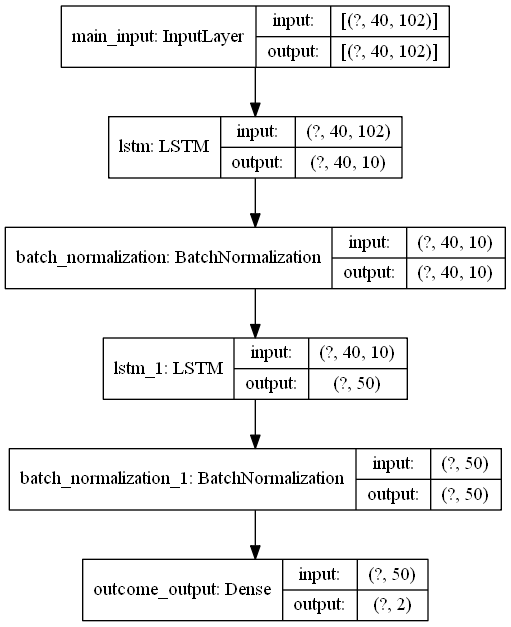

In [ ]:
cls.summary()

plot_model(
    cls,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

# pred_cls.summary()

# plot_model(
#     pred_cls,
#     to_file="model.png",
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
# )

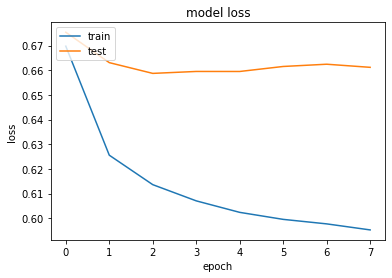

In [ ]:
plt.plot(history.history['loss'], label = "train")
plt.plot(history.history['val_loss'], label = "test")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<AxesSubplot:>

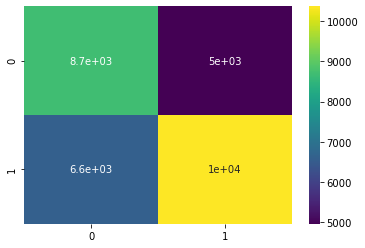

In [ ]:
confusion = confusion_matrix(test_y, preds)
sns.heatmap(confusion, annot=True, cmap='viridis')#, categories = ['Negative', 'Positive'])

In [ ]:
print(len(fp_list))
print(len(fn_list))
print(len(tp_list))
print(len(tn_list))

4959
6602
10369
8707


In [ ]:
y_train = [np.argmax(i) for i in train_y]
print(len([i for i in y_train if i ==0]))
print(len([i for i in y_train if i ==1]))

46764
46364


In [ ]:
y_val = [np.argmax(i) for i in val_y]
print(len([i for i in y_val if i ==0]))
print(len([i for i in y_val if i ==1]))

9249
9439


In [ ]:
#y_val = [np.argmax(i) for i in val_y]
print(len([i for i in test_y if i ==0]))
print(len([i for i in test_y if i ==1]))

13666
16971


In [ ]:
#cls = load_model("%s/%s_%s/cls/backup_0.5_with_all.h5" % (dataset_ref, cls_method, method_name))
#cls.summary()

In [ ]:
#with open ("%s/%s_%s/cls/params.pickle"% (dataset_ref, cls_method, method_name), 'rb') as f:
#    params = pickle.load(f)

#params